In [51]:
pip install pandas openpyxl matplotlib seaborn fuzzywuzzy networkx

Note: you may need to restart the kernel to use updated packages.


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import matplotlib.image as mpimg
import geopandas as gpd
from fuzzywuzzy import process
import networkx as nx

In [54]:
df = pd.read_excel('datasets/artigos_processado.xlsx', engine='openpyxl')
print(df.head())

  Publication Type                                            Authors  \
0                J           Yang, L; Chen, X; Perlaza, SM; Zhang, JS   
1                C                          Chakraborty, T; Datta, SK   
2                C     Velmurugadass, P; Dhanasekaran, S; Sasikala, S   
3                C         Sahoo, S; Sahoo, KS; Sahoo, B; Gandomi, AH   
4                J  Xu, XL; Huang, QH; Yin, XC; Abbasi, M; Khosrav...   

  Book Authors        Book Editors Book Group Authors  \
0          NaN                 NaN                NaN   
1          NaN                 NaN               IEEE   
2          NaN  Paul, S; Verma, JK                NaN   
3          NaN                 NaN               IEEE   
4          NaN                 NaN                NaN   

                                   Author Full Names Book Author Full Names  \
0  Yang, Lei; Chen, Xu; Perlaza, Samir M.; Zhang,...                    NaN   
1            Chakraborty, Tanmy; Datta, Soumya Kanti        

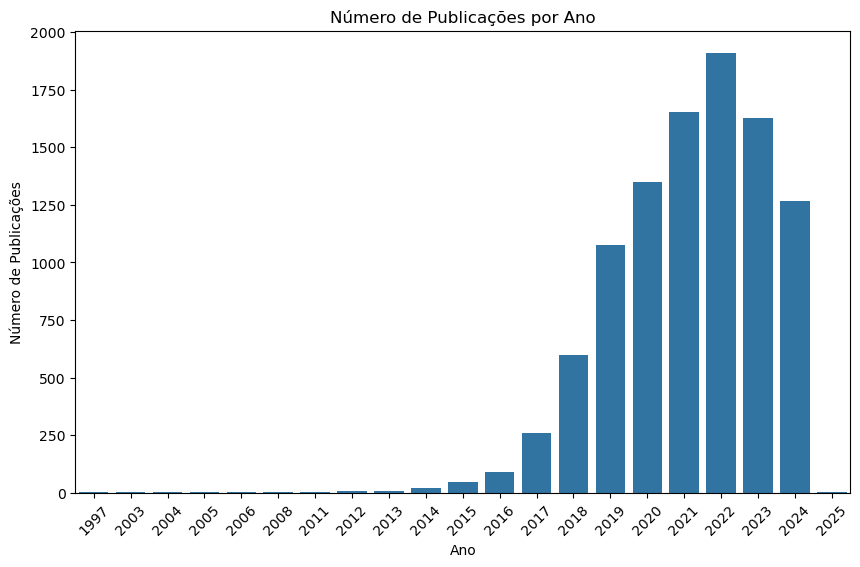

In [55]:
publicacoes_por_ano = df['Publication Year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=publicacoes_por_ano.index, y=publicacoes_por_ano.values)
plt.title('Número de Publicações por Ano')
plt.xlabel('Ano')
plt.ylabel('Número de Publicações')
plt.xticks(rotation=45)
plt.show()

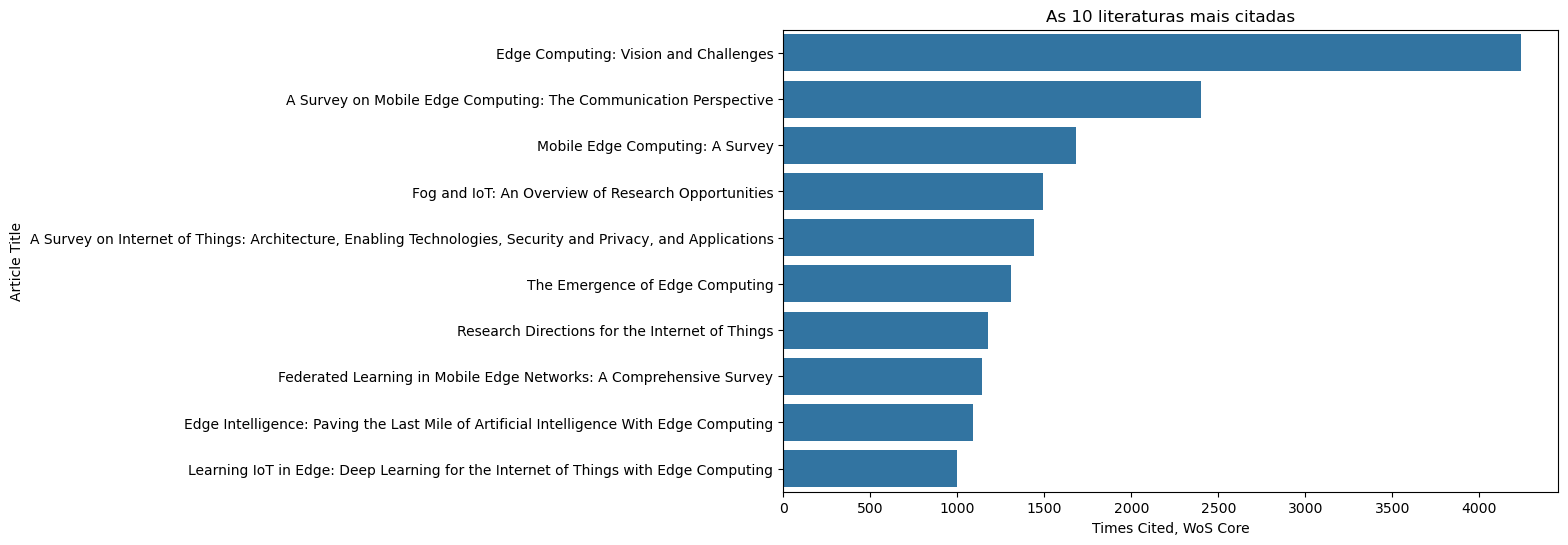

In [10]:
# 1. As 10 literaturas mais citadas

literature_data = df[['Article Title', 'Times Cited, WoS Core']].sort_values('Times Cited, WoS Core', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='Times Cited, WoS Core', y='Article Title', data=literature_data)
plt.title('As 10 literaturas mais citadas')
plt.show() 

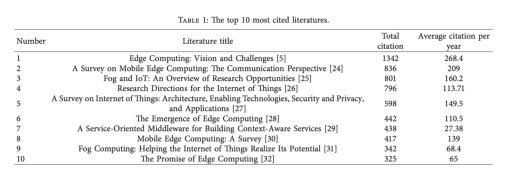

In [56]:
img = mpimg.imread('imgs/the-top-10-most-cited literatures.png')  
plt.imshow(img)
plt.axis('off') 
plt.show()


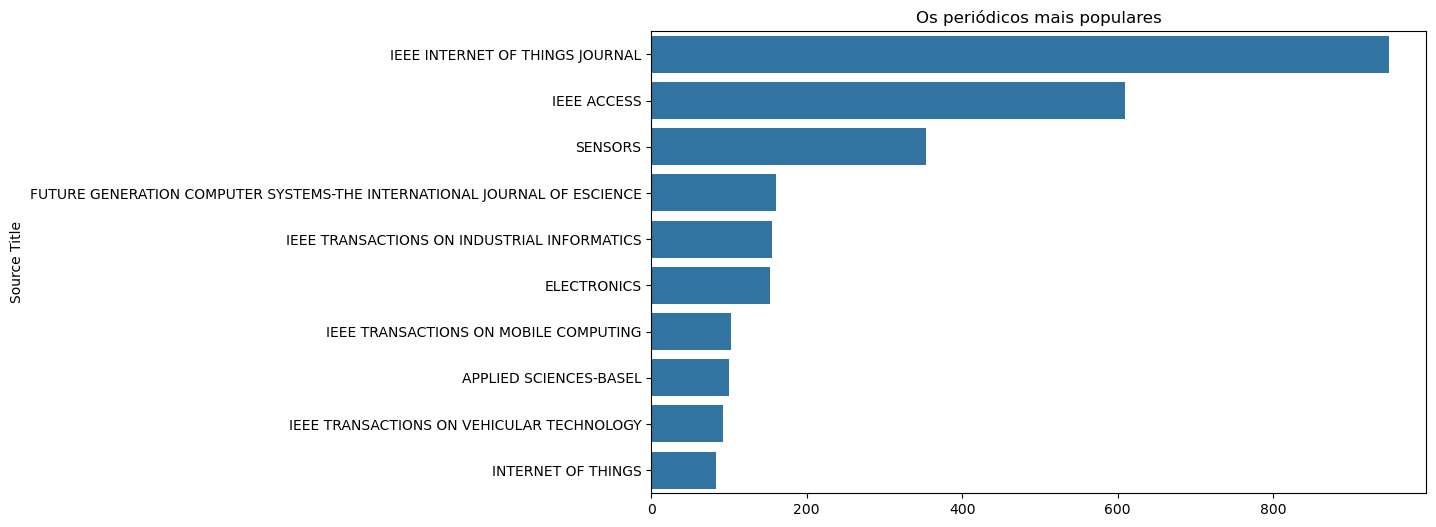

In [57]:
# 2. Os periódicos mais populares

journal_data = df['Source Title'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=journal_data.values, y=journal_data.index)
plt.title('Os periódicos mais populares')
plt.show() 

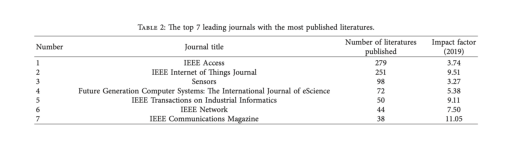

In [58]:
import matplotlib.image as mpimg
img = mpimg.imread('imgs/The-top-7-leading-journals-with-the-most-published-literatures.png')  
plt.imshow(img)
plt.axis('off') 
plt.show()

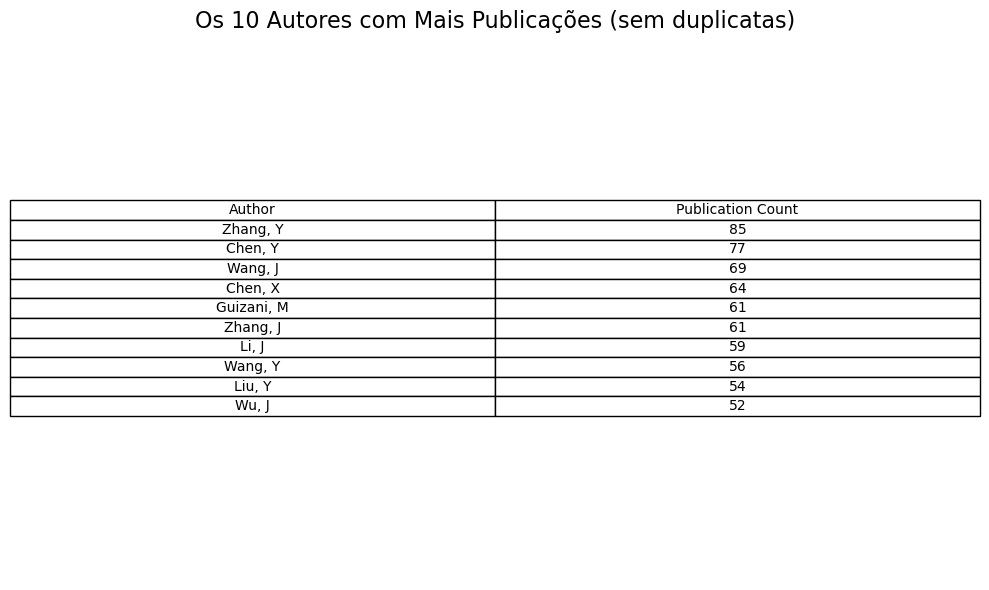

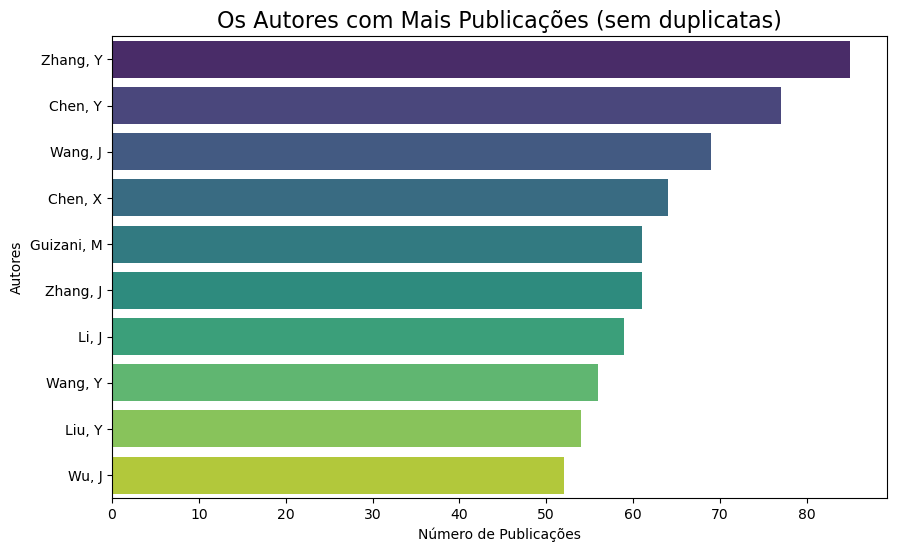

In [83]:
df['Authors'] = df['Authors'].str.split('; ')
df = df.explode('Authors')

df_unique = df.drop_duplicates(subset=['Authors', 'Article Title'])  

author_data = df_unique['Authors'].value_counts().head(10)

author_df = author_data.reset_index()
author_df.columns = ['Author', 'Publication Count']

plt.figure(figsize=(10, 6))
plt.table(cellText=author_df.values,
          colLabels=author_df.columns,
          cellLoc='center',
          loc='center')

plt.axis('off')  
plt.title('Os 10 Autores com Mais Publicações (sem duplicatas)', fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Publication Count', y='Author', data=author_df, hue='Author', palette='viridis', dodge=False)
plt.title('Os Autores com Mais Publicações (sem duplicatas)', fontsize=16)
plt.xlabel('Número de Publicações')
plt.ylabel('Autores')
plt.legend().set_visible(False)  
plt.show()

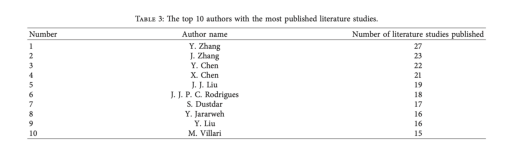

In [65]:
img = mpimg.imread('imgs/The-top-10-authors-with-the-most-published.png')  
plt.imshow(img)
plt.axis('off') 
plt.show()


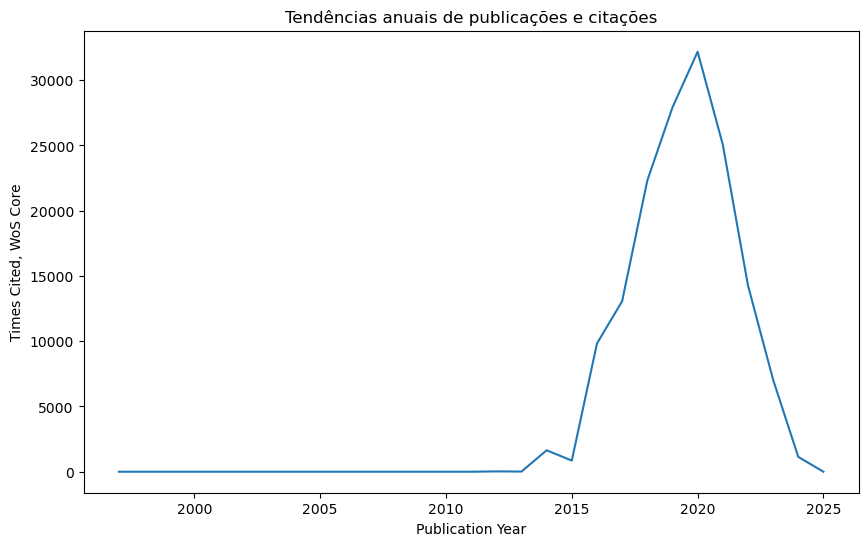

In [60]:
# 4. Tendências anuais de publicações e citações
yearly_trend = df.groupby('Publication Year')['Times Cited, WoS Core'].sum().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(x='Publication Year', y='Times Cited, WoS Core', data=yearly_trend)
plt.title('Tendências anuais de publicações e citações')
plt.show() 

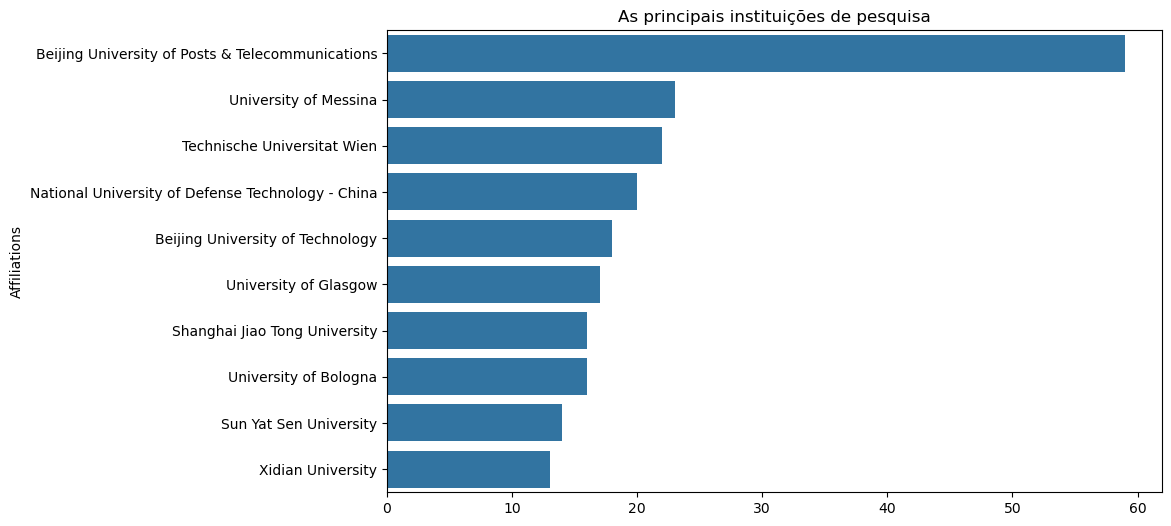

In [61]:
# 5. As principais instituições de pesquisa
institutions_data = df['Affiliations'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=institutions_data.values, y=institutions_data.index)
plt.title('As principais instituições de pesquisa')
plt.show()

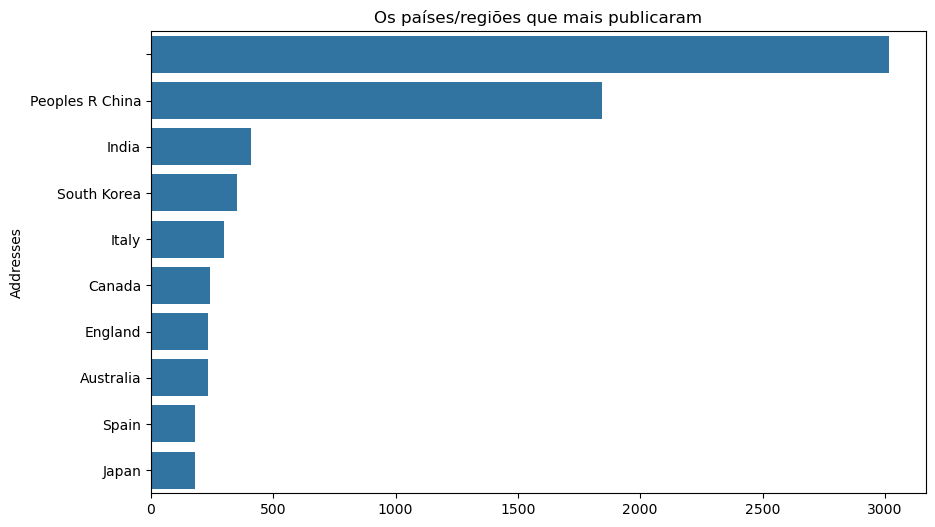

In [62]:
# 6. Os países/regiões que mais publicaram
countries_data = df['Addresses'].fillna('').apply(lambda x: str(x).split(',')[-1].strip()).value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=countries_data.values, y=countries_data.index)
plt.title('Os países/regiões que mais publicaram')
plt.show()

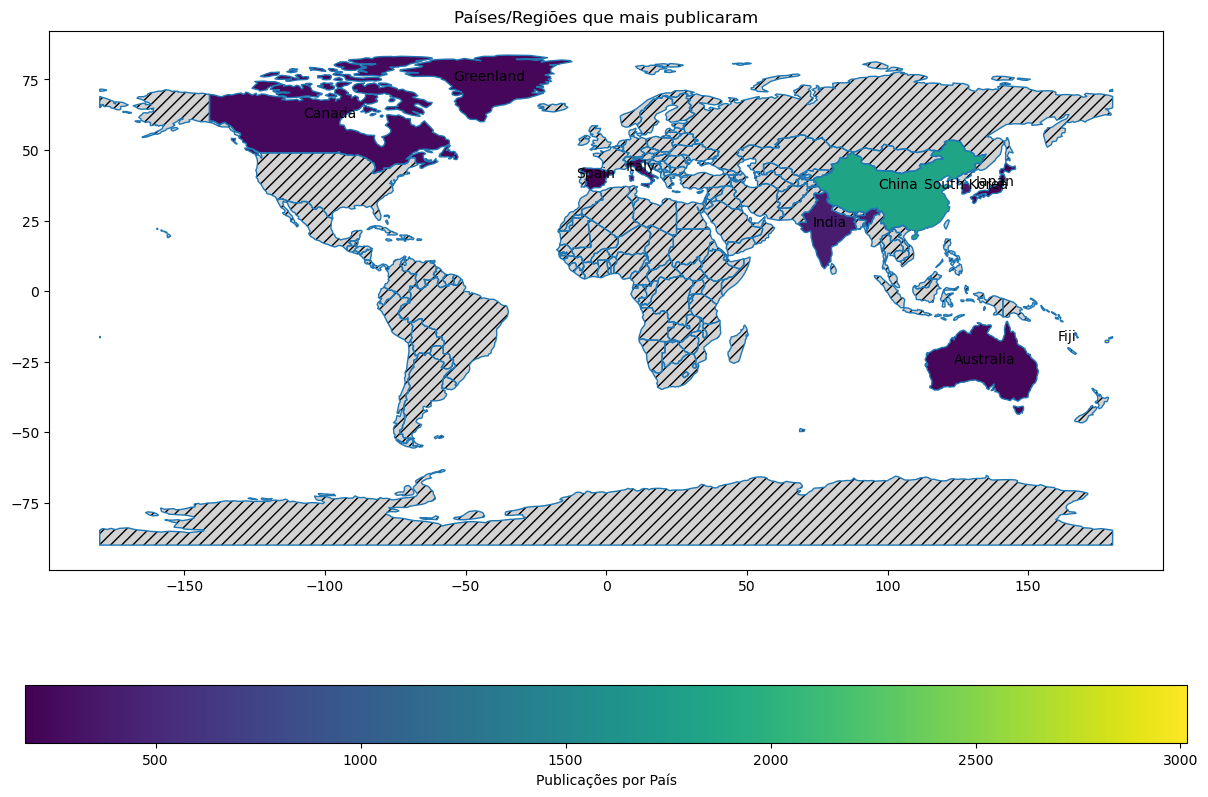

In [63]:


world = gpd.read_file('datasets/map/ne_110m_admin_0_countries.shp')

countries_data = df['Addresses'].fillna('').apply(lambda x: str(x).split(',')[-1].strip()).value_counts().head(10)

countries_df = pd.DataFrame(countries_data).reset_index()
countries_df.columns = ['Country', 'Publication Count']

world['ADMIN'] = world['ADMIN'].str.strip().str.title()

def get_best_match(country_name, choices, scorer=None):
    match, score = process.extractOne(country_name, choices)
    return match

geo_countries = world['ADMIN'].unique()

countries_df['Country'] = countries_df['Country'].apply(lambda x: get_best_match(x, geo_countries))

merged = world.merge(countries_df, how="left", left_on="ADMIN", right_on="Country")

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
merged.plot(column='Publication Count', ax=ax, legend=True,
            legend_kwds={'label': "Publicações por País",
                         'orientation': "horizontal"},
            missing_kwds={"color": "lightgrey",
                          "label": "No data",
                          "hatch": "///"})

for idx, row in merged.iterrows():
    if row['Publication Count'] > 0:
        ax.annotate(text=row['Country'], xy=row.geometry.centroid.coords[0], ha='center')

plt.title('Países/Regiões que mais publicaram')
plt.show()


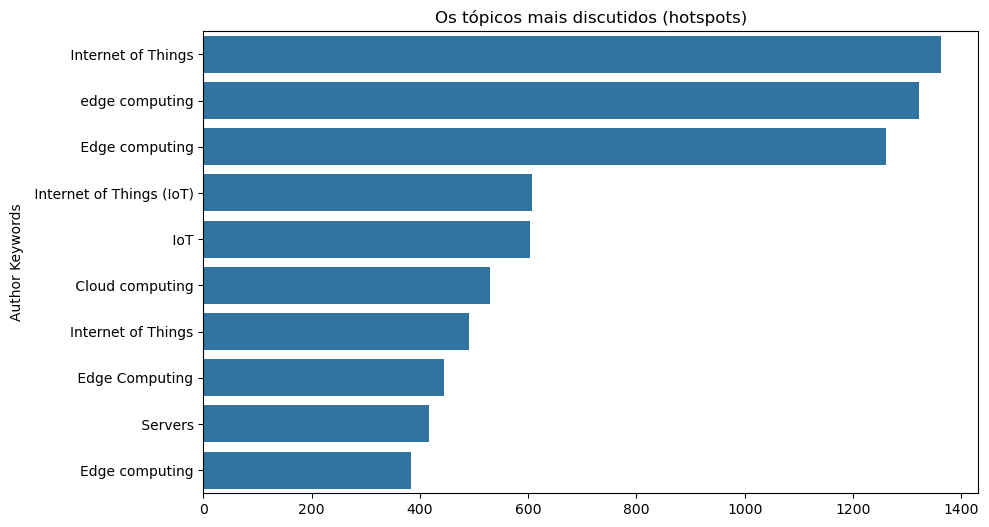

In [64]:
# 7. Os tópicos mais discutidos (hotspots)
hotspot_data = df['Author Keywords'].str.split(';').explode().value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=hotspot_data.values, y=hotspot_data.index)
plt.title('Os tópicos mais discutidos (hotspots)')
plt.show()

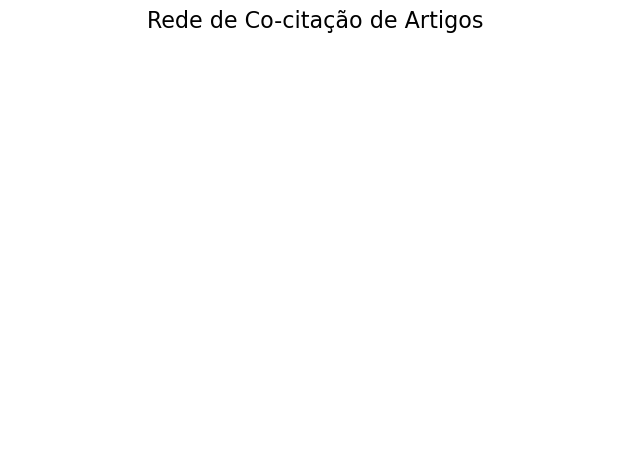

In [44]:

co_citations = []

for index, row in df.iterrows():
    title = row['Article Title']
    
    if pd.notna(row['Cited References']):
        cited_refs = row['Cited References'].split(';')  
        
        for cited in cited_refs:
            co_citations.append((title.strip(), cited.strip()))

co_citation_df = pd.DataFrame(co_citations, columns=['source', 'target'])

co_citation_counts = co_citation_df.value_counts().reset_index(name='weight')


G = nx.from_pandas_edgelist(co_citation_counts, source='source', target='target', edge_attr='weight', create_using=nx.Graph())

pos = nx.spring_layout(G, k=0.5, iterations=50)

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue', alpha=0.7)

nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] * 0.1 for u, v in G.edges()], alpha=0.5, edge_color='gray')

nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

plt.title('Rede de Co-citação de Artigos', fontsize=16)
plt.axis('off') 
plt.tight_layout()

plt.show()
